## kNN Classifiers 
#### In this notebook we will explore the kNN-Classifier
We will have a look into how the classifier works and how it performs under certain circumstances\
Let's start by importing crucial packages

In [27]:
# imports for the script
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## In the following we will create a class instance of the classifier
This class instance was given however it was modified as follows:

#### Added Methods and Differences

1. **`normalize` Method**  
   - **Purpose**: Scales each feature in a dataset to the \([0,1]\) range by applying a simple min–max normalization.  
   - **Usage**: Useful when you want all attributes to lie between 0 and 1 before running kNN, which can improve performance for distance-based algorithms.

2. **`getClassProbs` Method**  
   - **Goal**: Instead of returning just a single class for each test instance, this method computes a probability distribution over all possible classes (i.e., the neighbor-based "posterior" probabilities).  
   - **Steps**:
     1. **Collect Unique Classes**  
        Extract all distinct labels from the training set (`self.Y_train.unique()`).
     2. **Distance Computation**  
        For each test instance, compute distances to every training instance (similar to `getDiscreteClassification`).
     3. **Select *k* Nearest Neighbors**  
        Sort distances in ascending order and keep only the top *k* closest training points.
     4. **Count Class Frequencies**  
        Retrieve the labels of those *k* neighbors and compute the frequency distribution using `value_counts(normalize=True)`. This gives each class’s relative frequency among the neighbors, acting as the posterior probability.
     5. **Fill Missing Classes**  
        Reindex the frequency counts so every class label appears. If a class is absent among the neighbors, its probability is set to 0.
     6. **Combine Probabilities**  
        Append each probability vector to a list, then convert that list into a DataFrame. Each row corresponds to one test instance, with columns for each possible class.

##### Contrast with Original `kNN` Class

- **`kNN` Constructor (`__init__`)**: Stores `k` (number of neighbors) and `exp` (exponent for Minkowski distance).
- **`fit` Method**: Saves the training data (`X_train`, `Y_train`) for later use.
- **`getDiscreteClassification` Method**: Returns a single "majority vote" class label for each test instance.
- **`Minkowski_distance` Method**: Computes the distance between two instances, using the exponent `exp`.

By adding **`getClassProbs`**, you can now retrieve a **full probability distribution** per test instance instead of just one predicted label. This is useful for measuring uncertainty or applying custom decision thresholds. The **`normalize`** method offers a straightforward approach to min–max scaling your data before fitting or classifying.


In [25]:
# Class of k-Nearest Neigbor Classifier


class kNN():
    def __init__(self, k = 3, exp = 2):
    # constructor for kNN classifier 
    # k is the number of neighbor for local class estimation
    # exp is the exponent for the Minkowski distance
        self.k = k
        self.exp = exp
      
    def fit(self, X_train, Y_train):
    # training k-NN method
    # X_train is the training data given with input attributes. n-th row correponds to n-th instance.
    # Y_train is the output data (output vector): n-th element of Y_train is the output value for n-th instance in X_train.
        self.X_train = X_train
        self.Y_train = Y_train   
         
    def getDiscreteClassification(self, X_test):
    # predict-class k-NN method
    # X_test is the test data given with input attributes. Rows correpond to instances
    # Method outputs prediction vector Y_pred_test:  n-th element of Y_pred_test is the prediction for n-th instance in X_test
    
        Y_pred_test = [] #prediction vector Y_pred_test for all the test instances in X_test is initialized to empty list []

   
        for i in range(len(X_test)):   #iterate over all instances in X_test
            test_instance = X_test.iloc[i] #i-th test instance 
            
            distances = []  #list of distances of the i-th test_instance for all the train_instance s in X_train, initially empty.
          
            for j in range(len(self.X_train)):  #iterate over all instances in X_train
                train_instance = self.X_train.iloc[j] #j-th training instance 
                distance = self.Minkowski_distance(test_instance, train_instance) #distance between i-th test instance and j-th training instance  
                distances.append(distance) #add the distance to the list of distances of the i-th test_instance
        
            # Store distances in a dataframe. The dataframe has the index of Y_train in order to keep the correspondence with the classes of the training instances 
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index = self.Y_train.index)
        
            # Sort distances, and only consider the k closest points in the new dataframe df_knn
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]
            
            # Note that the index df_knn.index of df_knn contains indices in Y_train of the k-closed training instances to 
            # the i-th test instance. Thus, the dataframe self.Y_train[df_knn.index] contains the classes of those k-closed 
            # training instances. Method value_counts() computes the counts (number of occurencies) for each class in 
            # self.Y_train[df_knn.index] in dataframe predictions. 
            predictions = self.Y_train[df_knn.index].value_counts()
                 
            # the first element of the index predictions.index contains the class with the highest count; i.e. the prediction y_pred_test.
            y_pred_test = predictions.index[0]

            # add the prediction y_pred_test to the prediction vector Y_pred_test for all the test instances in X_test
            Y_pred_test.append(y_pred_test)
        
        return Y_pred_test

    
    def Minkowski_distance(self, x1, x2):
    # computes the Minkowski distance of x1 and x2 for two labeled instances (x1,y1) and (x2,y2)
    
        # Set initial distance to 0
        distance = 0
    
        # Calculate Minkowski distance using the exponent exp
        for i in range(len(x1)):
            distance = distance + abs(x1.iloc[i] - x2.iloc[i])**self.exp
        
        distance = distance**(1/self.exp)
    
        return distance
    
    def normalize(self, data):
        normalized_data = (data-data.min())/(data.max()-data.min())
        return normalized_data
    


    def getPrediction(self, X_test):
        """
        k-NN regression method.
        For each test instance, finds the k nearest neighbors, then returns
        the AVERAGE of their Y_train values (a continuous value).
        
        Output:
            A pandas.DataFrame with one column ("prediction"), containing
            the regression prediction for each test instance.
        """
        pred_values = []

        for i in range(len(X_test)):
            test_instance = X_test.iloc[i]
            
            # Calculate distances
            distances = []
            for j in range(len(self.X_train)):
                train_instance = self.X_train.iloc[j]
                dist = self.Minkowski_distance(test_instance, train_instance)
                distances.append(dist)
            
            # Sort by distance and pick the k nearest neighbors
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index=self.Y_train.index)
            df_knn = df_dists.sort_values(by='dist').head(self.k)
            
            # Take the mean of the Y_train values for these k neighbors
            mean_value = self.Y_train[df_knn.index].mean()
            pred_values.append(mean_value)
        
        # Return predictions as a DataFrame
        df_pred = pd.DataFrame(pred_values, columns=["prediction"])
        return df_pred
        

    def getClassProbs(self, X_test):
        """
        Computes, for each test instance in X_test, the posterior class probabilities 
        among the k nearest neighbors in the training set.
        
        Returns:
            A pandas.DataFrame where each row corresponds to a test instance and each 
            column is a class, containing probabilities for belonging to that class.
        """
        classes = self.Y_train.unique()
        
        #init probability vector per test instance
        probs_list = []
        
        # For each test instance:
        for i in range(len(X_test)):
            test_instance = X_test.iloc[i]
            distances = []
            
            # Compute distance from this test instance to each training instance
            for j in range(len(self.X_train)):
                train_instance = self.X_train.iloc[j]
                dist = self.Minkowski_distance(test_instance, train_instance)
                distances.append(dist)
            
            # Create a DataFrame of distances and sort them
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index=self.Y_train.index)
            df_dists.sort_values(by='dist', inplace=True)
            
            # Take the k nearest neighbors
            df_knn = df_dists[:self.k]
            
            # Get their classes from Y_train
            neighbor_classes = self.Y_train[df_knn.index]
            
            # Compute normalized value counts => posterior probability for each class
            neighbor_counts = neighbor_classes.value_counts(normalize=True)
            
            #  Reindex so all classes appear as columns (missing ones get probability 0)
            neighbor_probs = neighbor_counts.reindex(classes, fill_value=0)
            
            #Append this row of probabilities
            probs_list.append(neighbor_probs)
        
        # Combine the rows probabilities into one DataFrame
        probs_df = pd.DataFrame(probs_list, columns=classes)
        return probs_df


#### Let's explore the glass data set a little bit:

In [26]:
df = pd.read_csv("glass.csv")
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1.51793,12.79,3.50,1.12,73.03,0.64,8.77,0.0,0.00,'build wind float'
1,1.51643,12.16,3.52,1.35,72.89,0.57,8.53,0.0,0.00,'vehic wind float'
2,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.0,0.00,'build wind float'
3,1.51299,14.40,1.74,1.54,74.55,0.00,7.59,0.0,0.00,tableware
4,1.53393,12.30,0.00,1.00,70.16,0.12,16.19,0.0,0.24,'build wind non-float'


In [4]:
df.shape

(214, 10)

**Let's start using our classifier class on the glass dataset:**

1. **Data Loading and Preparation**  
   - We load the *glass.csv* dataset into a DataFrame, extract the target column (`Y = data['class']`), and store the remaining features in `X`.  
   - We then split the data into training and test sets (`X_train`, `X_test`, `Y_train`, `Y_test`) using an approximate 66%–34% split.

2. **Parameter Range**  
   - We define a list of \( k \) values for kNN in `k_range`. For each \( k \), we will train a kNN classifier and record both the training accuracy and the test accuracy.

3. **Accuracy Arrays**  
   - `trainAcc` and `testAcc` store accuracy scores for the *original* data.  
   - `trainAcc_norm` and `testAcc_norm` are placeholders (currently unused in the shown loop) for normalized data accuracy.

4. **Main Loop Over \( k \)**  
   - For each \( k \) in `k_range`:  
     1. We instantiate the classifier `clf = kNN(k)`.  
     2. We create normalized versions of `X_train` and `X_test` (although in this example we do not actually use them for fitting).  
     3. We fit the classifier on the unnormalized data and generate predictions on both the training and test sets.  
     4. We compute accuracies using `accuracy_score` and store them in `trainAcc` and `testAcc`.


In [5]:
##################################################
# Hold-out testing: Training and Test set creation
##################################################

data = pd.read_csv('glass.csv')
data.head()
Y = data['class']
X = data.drop(['class'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)


# range for the values of parameter k for kNN

k_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

trainAcc = np.zeros(len(k_range))
testAcc = np.zeros(len(k_range))

trainAcc_norm = np.zeros(len(k_range))
testAcc_norm = np.zeros(len(k_range))


index = 0 
# for k  in  k_range:
#     clf = kNN(k)
#     clf.fit(X_train, Y_train)
#     Y_predTrain = clf.getDiscreteClassification(X_train)
#     Y_predTest = clf.getDiscreteClassification(X_test)
#     trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
#     testAcc[index] = accuracy_score(Y_test, Y_predTest)
#     index += 1

for j in k_range:
    clf = kNN(j)
    norm_x = clf.normalize(X_train)
    norm_xtest = clf.normalize(X_test)
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.getDiscreteClassification(X_train)
    Y_predTest = clf.getDiscreteClassification(X_test)
    trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc[index] = accuracy_score(Y_test, Y_predTest)
    index += 1

print('max train accuracy:', max(trainAcc))
print('max test accuracy:', max(testAcc))

#########################################
# Plot of training and test accuracies
#########################################

# plt.plot(k_range,trainAcc,'ro-',k_range,testAcc,'bv--')
# plt.legend(['Training Accuracy','Test Accuracy'])
# plt.xlabel('k')
# plt.ylabel('Accuracy')

# plt.plot(k_range,trainAcc,'ro-',k_range,testAcc,'bv--')
# plt.legend(['Training Accuracy','Test Accuracy'])
# plt.xlabel('k')
# plt.ylabel('Accuracy')
print(' train accuracy:', trainAcc)
print(' test accuracy:', testAcc)


max train accuracy: 1.0
max test accuracy: 0.6164383561643836
 train accuracy: [1.         0.85106383 0.73758865 0.75177305 0.73758865 0.70921986
 0.71631206 0.69503546 0.72340426 0.70921986 0.68794326 0.66666667
 0.65248227 0.63120567 0.63829787 0.62411348]
 test accuracy: [0.61643836 0.5890411  0.5890411  0.57534247 0.54794521 0.54794521
 0.61643836 0.5890411  0.57534247 0.57534247 0.56164384 0.5890411
 0.57534247 0.54794521 0.54794521 0.57534247]


### Next we will train the same classifier on normalized data (max-min normalization)

In [6]:
# Training with normalized data (max-min normalization)
trainAcc_max_min = np.zeros(len(k_range))
testAcc_max_min = np.zeros(len(k_range)) 

index = 0
for j in k_range:
    clf = kNN(j)
    norm_x = clf.normalize(X_train)
    norm_xtest = clf.normalize(X_test)
    clf.fit(norm_x, Y_train)
    probs_df = clf.getClassProbs(X_test)
    print("k = ",j, ", Posterior probabilities for test instances:")
    print(probs_df.head())
    Y_predTrain = clf.getDiscreteClassification(norm_x)
    Y_predTest = clf.getDiscreteClassification(norm_xtest)
    trainAcc_max_min[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc_max_min[index] = accuracy_score(Y_test, Y_predTest)
    index += 1

k =  1 , Posterior probabilities for test instances:
            'build wind float'  'build wind non-float'  headlamps  \
proportion                 0.0                     0.0        0.0   
proportion                 0.0                     0.0        0.0   
proportion                 0.0                     0.0        0.0   
proportion                 0.0                     0.0        0.0   
proportion                 0.0                     0.0        0.0   

            'vehic wind float'  containers  tableware  
proportion                 0.0         0.0        1.0  
proportion                 0.0         0.0        1.0  
proportion                 0.0         0.0        1.0  
proportion                 0.0         0.0        1.0  
proportion                 0.0         0.0        1.0  
k =  3 , Posterior probabilities for test instances:
            'build wind float'  'build wind non-float'  headlamps  \
proportion                 0.0                     0.0   0.333333   
propo

### To see if we get better results we can also try using the sklearn scaler method

In [7]:
#trying with normalized data (using scaler)
from sklearn import preprocessing

# X = pd.DataFrame(preprocessing.scale(X), columns=X.columns)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)
X_train = pd.DataFrame(preprocessing.scale(X_train), columns=X_train.columns)
X_test = pd.DataFrame(preprocessing.scale(X_test), columns=X_test.columns)

index = 0
for j in k_range:
    clf = kNN(j)
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.getDiscreteClassification(X_train)
    Y_predTest = clf.getDiscreteClassification(X_test)
    trainAcc_norm[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc_norm[index] = accuracy_score(Y_test, Y_predTest)
    index += 1

# plt.plot(k_range,trainAcc,'ro-',k_range,testAcc,'bv--')
# plt.legend(['Training Accuracy','Test Accuracy'])
# plt.xlabel('k')
# plt.ylabel('Accuracy')

### Plotting the results
To see and compare our resuluts for all values of k and over all preprocessing possibalities,\
let's plot them next to each other

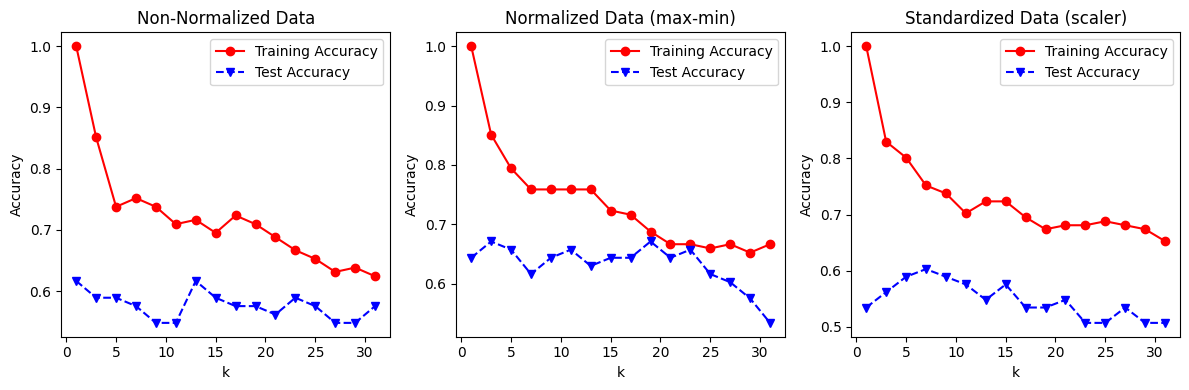

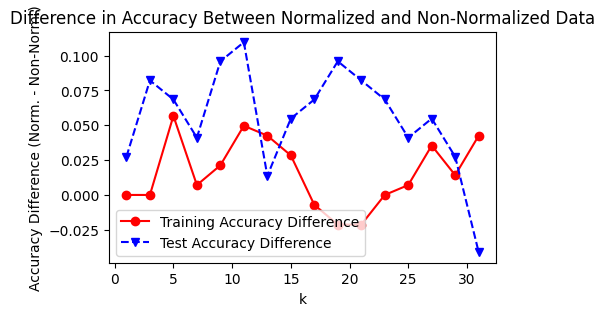

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot for non-normalized data
axs[0].plot(k_range, trainAcc, 'ro-', label='Training Accuracy')
axs[0].plot(k_range, testAcc, 'bv--', label='Test Accuracy')
axs[0].set_title("Non-Normalized Data")
axs[0].set_xlabel("k")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot for normalized data
axs[1].plot(k_range, trainAcc_norm, 'ro-', label='Training Accuracy')
axs[1].plot(k_range, testAcc_norm, 'bv--', label='Test Accuracy')
axs[1].set_title("Normalized Data (max-min)")
axs[1].set_xlabel("k")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

# Plot for normalized data
axs[2].plot(k_range, trainAcc_max_min, 'ro-', label='Training Accuracy')
axs[2].plot(k_range, testAcc_max_min, 'bv--', label='Test Accuracy')
axs[2].set_title("Standardized Data (scaler)")
axs[2].set_xlabel("k")
axs[2].set_ylabel("Accuracy")
axs[2].legend()

plt.tight_layout()
plt.show()

# Calculate the differences: (Normalized - Non-Normalized)
diffTrain = trainAcc_norm - trainAcc
diffTest = testAcc_norm - testAcc

# Plot the differences in accuracy.
plt.figure(figsize=(5, 3))
plt.plot(k_range, diffTrain, 'ro-', label="Training Accuracy Difference")
plt.plot(k_range, diffTest, 'bv--', label="Test Accuracy Difference")
plt.xlabel("k")
plt.ylabel("Accuracy Difference (Norm. - Non-Norm.)")
plt.title("Difference in Accuracy Between Normalized and Non-Normalized Data")
plt.legend()
plt.show()

### Results
As we can see test accuracy drastically improves when normalizing the data.\
We can also see a slight improvement in the training accuracy. 
Lets's check the improvement in numbers

In [10]:
print('max train accuracy:', max(trainAcc))
print('max test accuracy:', max(testAcc))
print('max train accuracy (normalized):', max(trainAcc_norm))
print('max test accuracy (normalized):', max(testAcc_norm))


max train accuracy: 1.0
max test accuracy: 0.6164383561643836
max train accuracy (normalized): 1.0
max test accuracy (normalized): 0.6712328767123288


### Testing kNN on Diabetes Data Set

In [11]:
sugar_data = pd.read_csv('diabetes.csv')

Y = sugar_data['class']
X = sugar_data.drop(['class'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

sugar_data.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


In [12]:
sugar_data.shape

(768, 9)

In [13]:
sugar_data.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [14]:
# Setting up training
# varialbles for Accuracies
trainAccDia = np.zeros(len(k_range))
testAccDia = np.zeros(len(k_range))

# training for non-normalized data
index = 0
for j in k_range:
    clf = kNN(j)
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.getDiscreteClassification(X_train)
    Y_predTest = clf.getDiscreteClassification(X_test)
    trainAccDia[index] = accuracy_score(Y_train, Y_predTrain)
    testAccDia[index] = accuracy_score(Y_test, Y_predTest)
    index += 1

In [15]:
# normalize the data (using max-min normalization)
trainAccDia_max_min = np.zeros(len(k_range))
testAccDia_max_min = np.zeros(len(k_range))

index = 0
for j in k_range:
    clf = kNN(j)
    norm_x = clf.normalize(X_train)
    norm_xtest = clf.normalize(X_test)
    clf.fit(norm_x, Y_train)
    Y_predTrain = clf.getDiscreteClassification(norm_x)
    Y_predTest = clf.getDiscreteClassification(norm_xtest)
    trainAccDia_max_min[index] = accuracy_score(Y_train, Y_predTrain)
    testAccDia_max_min[index] = accuracy_score(Y_test, Y_predTest)
    index += 1

In [16]:
# normalizing data using scaler

X_train_norm = pd.DataFrame(preprocessing.scale(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(preprocessing.scale(X_test), columns=X_test.columns)

trainAccDia_norm = np.zeros(len(k_range))
testAccDia_norm = np.zeros(len(k_range))

# training for normalized data
index = 0 
for j in k_range:
    clf = kNN(j)
    clf.fit(X_train_norm, Y_train)
    Y_predTrain = clf.getDiscreteClassification(X_train_norm)
    Y_predTest = clf.getDiscreteClassification(X_test_norm)
    trainAccDia_norm[index] = accuracy_score(Y_train, Y_predTrain)
    testAccDia_norm[index] = accuracy_score(Y_test, Y_predTest)
    index += 1

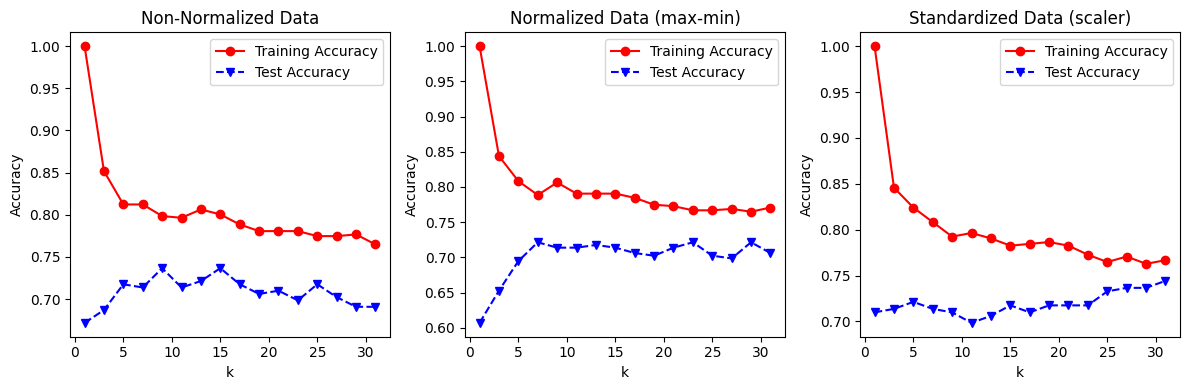

In [17]:
#Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot for non-normalized data
axs[0].plot(k_range, trainAccDia, 'ro-', label='Training Accuracy')
axs[0].plot(k_range, testAccDia, 'bv--', label='Test Accuracy')
axs[0].set_title("Non-Normalized Data")
axs[0].set_xlabel("k")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot for normalized data (max-min normalization)
axs[1].plot(k_range, trainAccDia_max_min, 'ro-', label='Training Accuracy')
axs[1].plot(k_range, testAccDia_max_min, 'bv--', label='Test Accuracy')
axs[1].set_title("Normalized Data (max-min)")
axs[1].set_xlabel("k")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

# Plot for normalized data (scaler)
axs[2].plot(k_range, trainAccDia_norm, 'ro-', label='Training Accuracy')
axs[2].plot(k_range, testAccDia_norm, 'bv--', label='Test Accuracy')
axs[2].set_title("Standardized Data (scaler)")
axs[2].set_xlabel("k")
axs[2].set_ylabel("Accuracy")
axs[2].legend()

plt.tight_layout()
plt.show()

In [18]:
# maximum accuracies
print('max train accuracy:', max(trainAccDia))
print('max test accuracy:', max(testAccDia))
print('max train accuracy (normalized):', max(trainAccDia_norm))
print('max test accuracy (normalized):', max(testAccDia_norm))
print('max train accuracy (max-min normalized):', max(trainAccDia_max_min))
print('max test accuracy (max-min normalized):', max(testAccDia_max_min))

max train accuracy: 1.0
max test accuracy: 0.7366412213740458
max train accuracy (normalized): 1.0
max test accuracy (normalized): 0.7442748091603053
max train accuracy (max-min normalized): 1.0
max test accuracy (max-min normalized): 0.7213740458015268


In [19]:
Yu = data["Na"]
def normalizeX_test( data):
        normalized_data = (data-data.min())/(data.max()-data.min())
        return normalized_data
normalizeX_test(Yu)

0      0.309774
1      0.215038
2      0.372932
3      0.551880
4      0.236090
         ...   
209    0.404511
210    0.320301
211    0.479699
212    0.291729
213    0.505263
Name: Na, Length: 214, dtype: float64

/var/folders/ml/fyq5x5t55wx4129dn03n32hm0000gn/T/ipykernel_65749/1655431842.py:67: RuntimeWarning: overflow encountered in scalar power
  distance = distance + abs(x1.iloc[i] - x2.iloc[i])**self.exp
/var/folders/ml/fyq5x5t55wx4129dn03n32hm0000gn/T/ipykernel_65749/1655431842.py:67: RuntimeWarning: overflow encountered in scalar power
  distance = distance + abs(x1.iloc[i] - x2.iloc[i])**self.exp
/var/folders/ml/fyq5x5t55wx4129dn03n32hm0000gn/T/ipykernel_65749/1655431842.py:67: RuntimeWarning: overflow encountered in scalar power
  distance = distance + abs(x1.iloc[i] - x2.iloc[i])**self.exp
/var/folders/ml/fyq5x5t55wx4129dn03n32hm0000gn/T/ipykernel_65749/1655431842.py:67: RuntimeWarning: overflow encountered in scalar power
  distance = distance + abs(x1.iloc[i] - x2.iloc[i])**self.exp
/var/folders/ml/fyq5x5t55wx4129dn03n32hm0000gn/T/ipykernel_65749/1655431842.py:67: RuntimeWarning: overflow encountered in scalar power
  distance = distance + abs(x1.iloc[i] - x2.iloc[i])**self.exp
/var/

Text(0, 0.5, 'Accuracy')

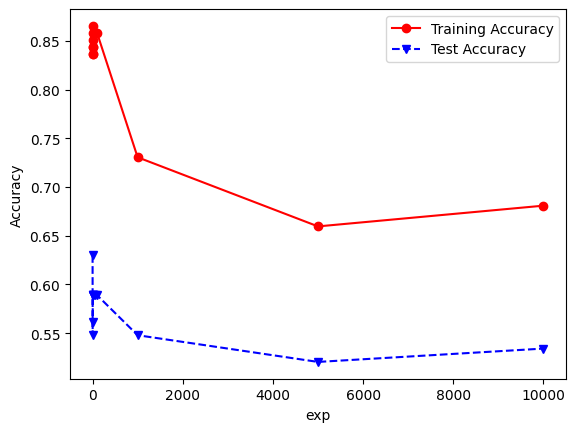

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from numpy.random import random
from sklearn.model_selection import train_test_split

##################################################
# Hold-out testing: Training and Test set creation
##################################################

data = pd.read_csv('glass.csv')
data.head()
Y = data['class']
X = data.drop(['class'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)


# range for the values of parameter exp for kNN

exp_range = [1, 2, 3, 4, 5, 10, 20, 50, 100, 1000, 5000, 10000]

trainAcc = np.zeros(len(exp_range))
testAcc = np.zeros(len(exp_range))


index = 0 
for exp  in  exp_range:
    clf = kNN(k = 3, exp = exp)
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.getDiscreteClassification(X_train)
    Y_predTest = clf.getDiscreteClassification(X_test)
    trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc[index] = accuracy_score(Y_test, Y_predTest)
    index += 1
   
    
#########################################
# Plot of training and test accuracies
#########################################
    
plt.plot(exp_range,trainAcc,'ro-',exp_range,testAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('exp')
plt.ylabel('Accuracy')


In [28]:
from sklearn.metrics import mean_absolute_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
mean_absolute_error(y_true, y_pred)

0.5

## Benchmarking the `getPrediction` Method on the `autoprice` Dataset

In this section, we evaluate our new **k-NN regression** function, `getPrediction`, which returns a continuous prediction for each test instance by averaging the \( k \) nearest neighbors’ \( Y \)-values in the training set. We proceed as follows:

1. **Data Loading**  
   - We load the `autoprice.csv` dataset and split it into feature vectors `X` and the target vector `Y`, where `Y` represents a continuous variable (e.g., a car’s price).

2. **Hold-Out Splitting**  
   - We divide the data into training and test subsets using `train_test_split`. By default, around 66% of the data is for training, and 34% for testing (though you can adjust the ratio if desired).

3. **Loop Over Multiple \( k \) Values**  
   - We define a list of \( k \) values (e.g., `[1, 3, 5, 7, ...]`) and for each \( k \):
     - Instantiate and fit the `kNN` model.
     - Call `getPrediction` on the training set and compute the **mean absolute error** (MAE) compared to the true training labels.
     - Call `getPrediction` on the test set and compute the MAE compared to the true test labels.
   - We store these MAE scores for later analysis.

4. **Normalization**  
   - To test whether feature scaling helps, we repeat the experiment with normalized versions of both `X_train` and `X_test` using the `normalize` method. This method scales each feature to the \([0,1]\) range, which can be beneficial in distance-based methods.

5. **Result Aggregation and Plotting**  
   - We record the MAE for each \( k \) (and for both raw and normalized data).  
   - The code then finds and prints which \( k \) achieved the lowest MAE on both the training and test sets.  
   - Optionally, we plot MAE vs. \( k \) to visualize how performance changes as we vary the number of neighbors.

Overall, this procedure allows us to **benchmark** the regression performance of our `kNN` class and **compare** different \( k \) values and normalization strategies using **mean absolute error** as the primary performance metric.


In [29]:
data = pd.read_csv('autoprice.csv')
data.head()
Y = data['class']
X = data.drop(['class'],axis=1)
data.head()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### Testing kNN-Regression for examplary k = 5 on the dataset

In [30]:
clf = kNN(k=5, exp=2)
clf.fit(X_train, Y_train)
predictions_df = clf.getPrediction(X_test)
mae = mean_absolute_error(Y_test, predictions_df['prediction'])
print(f"Mean Absolute Error (k=5): {mae:.2f}")

Mean Absolute Error (k=5): 1644.95


In [31]:
results = pd.DataFrame({
    'Actual': Y_test.values,
    'Predicted': predictions_df['prediction'].values
})
print(results.head(10))

   Actual  Predicted
0   13200    22540.6
1   19045    15745.6
2    9989    10457.2
3    6989     9156.2
4   15510    13597.0
5   10295    12114.8
6    9980     9032.4
7    6669     6014.2
8    7053     9027.0
9    7975     9029.6


=== Without Normalization ===
Lowest Training MAE: 31.53 at k = 1
Lowest Test MAE: 1361.59 at k = 17
=== With Normalization ===
Lowest Training MAE (norm): 31.53 at k = 1
Lowest Test MAE (norm): 1638.24 at k = 15


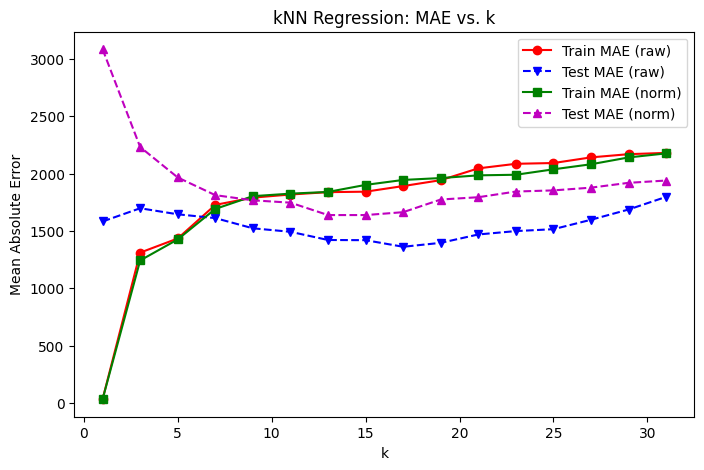

In [32]:

k_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

# Evaluating with MAE instead of accuracy as we are doing regression
trainMAE = np.zeros(len(k_range)) 
testMAE = np.zeros(len(k_range))  

trainMAE_norm = np.zeros(len(k_range))  
testMAE_norm = np.zeros(len(k_range))   

index = 0

for k in k_range:
    clf = kNN(k)
    
    clf.fit(X_train, Y_train)
    trainPredDF = clf.getPrediction(X_train)  
    trainMAE[index] = mean_absolute_error(Y_train, trainPredDF['prediction'])
    
    # Predict on test set
    testPredDF = clf.getPrediction(X_test)
    testMAE[index] = mean_absolute_error(Y_test, testPredDF['prediction'])
    
    #  With Normalization
    # Normalize the features
    X_train_norm = clf.normalize(X_train)
    X_test_norm  = clf.normalize(X_test)
    
    # Fit on normalized training data
    clf.fit(X_train_norm, Y_train)
    
    # Predict on normalized training set
    trainPredNormDF = clf.getPrediction(X_train_norm)
    trainMAE_norm[index] = mean_absolute_error(Y_train, trainPredNormDF['prediction'])
    
    # Predict on normalized test set
    testPredNormDF = clf.getPrediction(X_test_norm)
    testMAE_norm[index] = mean_absolute_error(Y_test, testPredNormDF['prediction'])
    
    index += 1

#results
print("=== Without Normalization ===")
print(f"Lowest Training MAE: {min(trainMAE):.2f} at k = {k_range[np.argmin(trainMAE)]}")
print(f"Lowest Test MAE: {min(testMAE):.2f} at k = {k_range[np.argmin(testMAE)]}")

print("=== With Normalization ===")
print(f"Lowest Training MAE (norm): {min(trainMAE_norm):.2f} at k = {k_range[np.argmin(trainMAE_norm)]}")
print(f"Lowest Test MAE (norm): {min(testMAE_norm):.2f} at k = {k_range[np.argmin(testMAE_norm)]}")

plt.figure(figsize=(8, 5))
plt.plot(k_range, trainMAE, 'ro-', label='Train MAE (raw)')
plt.plot(k_range, testMAE, 'bv--', label='Test MAE (raw)')
plt.plot(k_range, trainMAE_norm, 'gs-', label='Train MAE (norm)')
plt.plot(k_range, testMAE_norm, 'm^--', label='Test MAE (norm)')
plt.legend()
plt.xlabel('k')
plt.ylabel('Mean Absolute Error')
plt.title('kNN Regression: MAE vs. k')
plt.show()
